LSTM Model – Cooling Load Forecasting (December 2023)

This notebook implements an LSTM-based neural network to forecast cooling energy consumption for December 2023. The model is trained on historical load data from the full year 2023 and uses past values as input sequences to predict future values.

Description:
The model is built and trained using PyTorch. It takes 15-minute resolution load data, prepares it into sequences, and learns the temporal patterns present in the earlier months to predict future consumption in December. The entire pipeline includes data loading, cleaning, normalization, sequence preparation, model training, forecasting, and evaluation.

Workflow:
- Load raw cooling load data from Excel (.xlsx)
- Normalize the data for stable LSTM training
- Split the dataset into training (January–November) and testing (December)
- Convert data into input-output sequences for supervised learning
- Train a simple LSTM model using MSE loss and the Adam optimizer
- Generate predictions for December 2023
- Evaluate performance using MAE and RMSE
- Plot results and export predictions to Excel

Outputs:
- Trained LSTM model file: cooling_lstm_fullmodel.pth
- Excel file with predictions: december_predictions.xlsx
- Visual plots:
    - cooling_december_prediction.png
    - full_year_with_december_overlay.png
    - cooling_actual_full_year.png

Usage:
Run all cells sequentially in a Google Colab or local Python environment after ensuring the dataset is uploaded and required libraries are installed.


Mounted at /content/drive
=== Cooling Load Forecasting with LSTM ===

[Step 1] Loading full-year data...
[Step 2] Splitting dataset into training and test sets...
Excel data loaded and cleaned.
Total records: 35040
Training records: 32065
Test records: 2975
[Step 3] Applying Min-Max normalization...
Normalization complete.
Train shape: (32065,)
Test shape: (2975,)
[Step 4] Creating input sequences for LSTM...
[Step 5] Training LSTM model...
Starting training with zero-sensitive loss...
Epoch  1/20 - Loss: 0.008665 - MAE: 0.021706 - RMSE: 0.047430
Epoch  2/20 - Loss: 0.002433 - MAE: 0.015980 - RMSE: 0.039238
Epoch  3/20 - Loss: 0.001992 - MAE: 0.014224 - RMSE: 0.036938
Epoch  4/20 - Loss: 0.001848 - MAE: 0.012859 - RMSE: 0.036945
Epoch  5/20 - Loss: 0.001757 - MAE: 0.013263 - RMSE: 0.036776
Epoch  6/20 - Loss: 0.001712 - MAE: 0.013029 - RMSE: 0.036429
Epoch  7/20 - Loss: 0.001676 - MAE: 0.013047 - RMSE: 0.036056
Epoch  8/20 - Loss: 0.001589 - MAE: 0.013140 - RMSE: 0.035951
Epoch  9/20 -

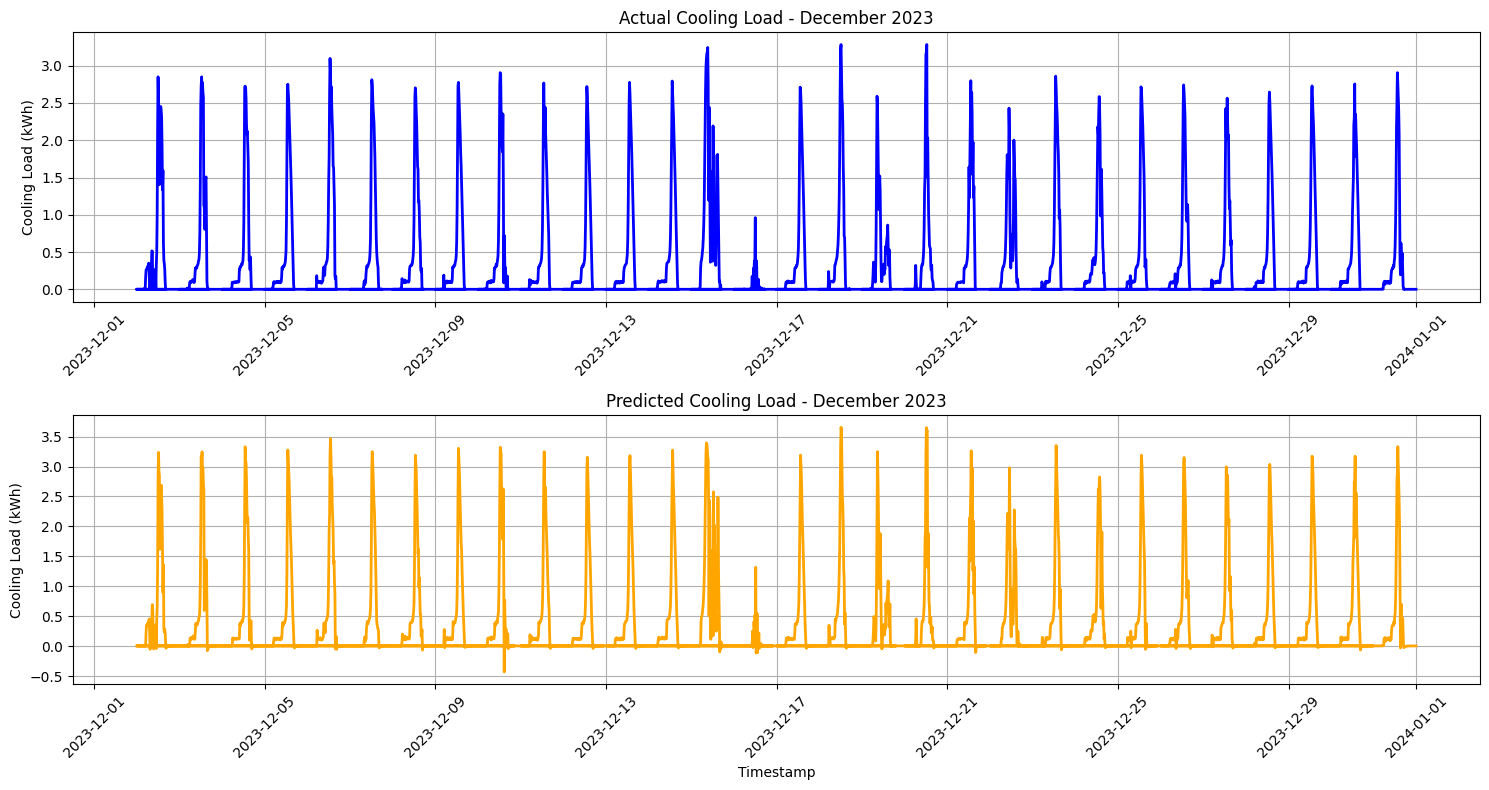

[Step 11] Plotting full year with December overlay...


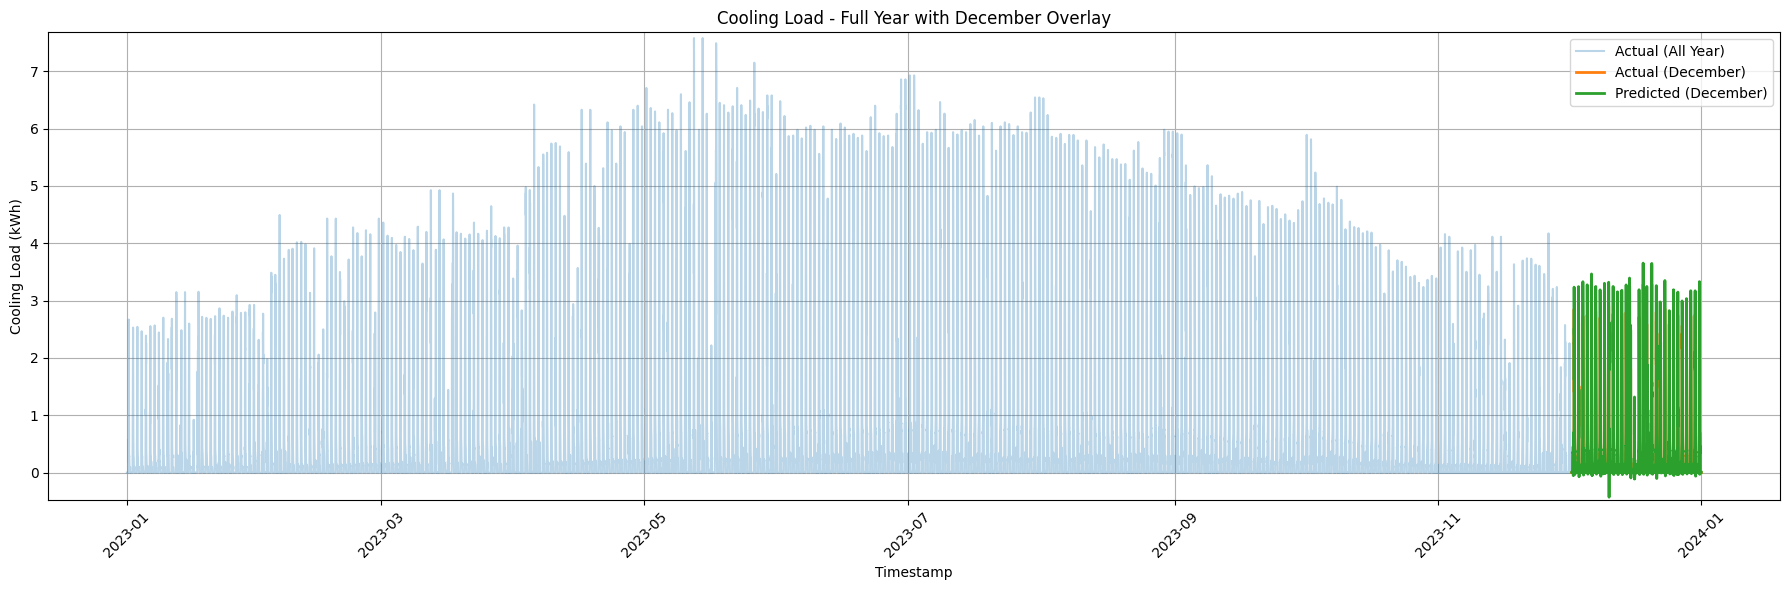

[Step 12] Plotting actual full-year data...


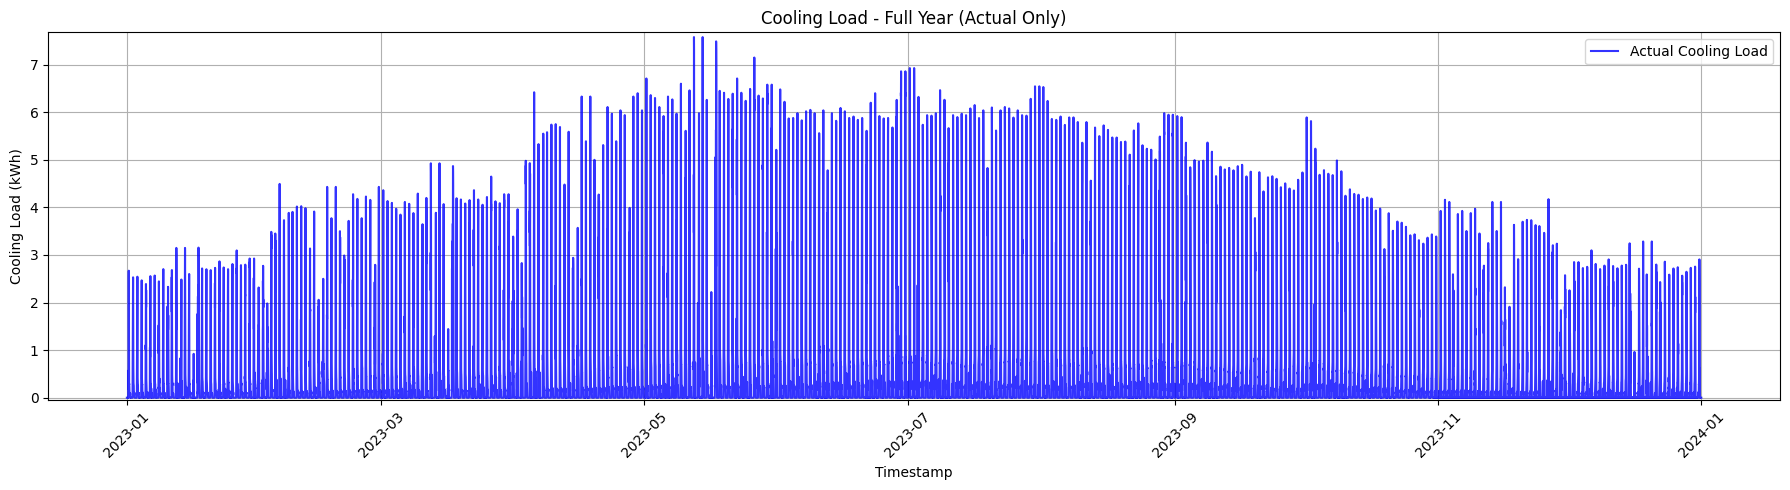

[Step 13] Plotting stacked full-year with predicted December...


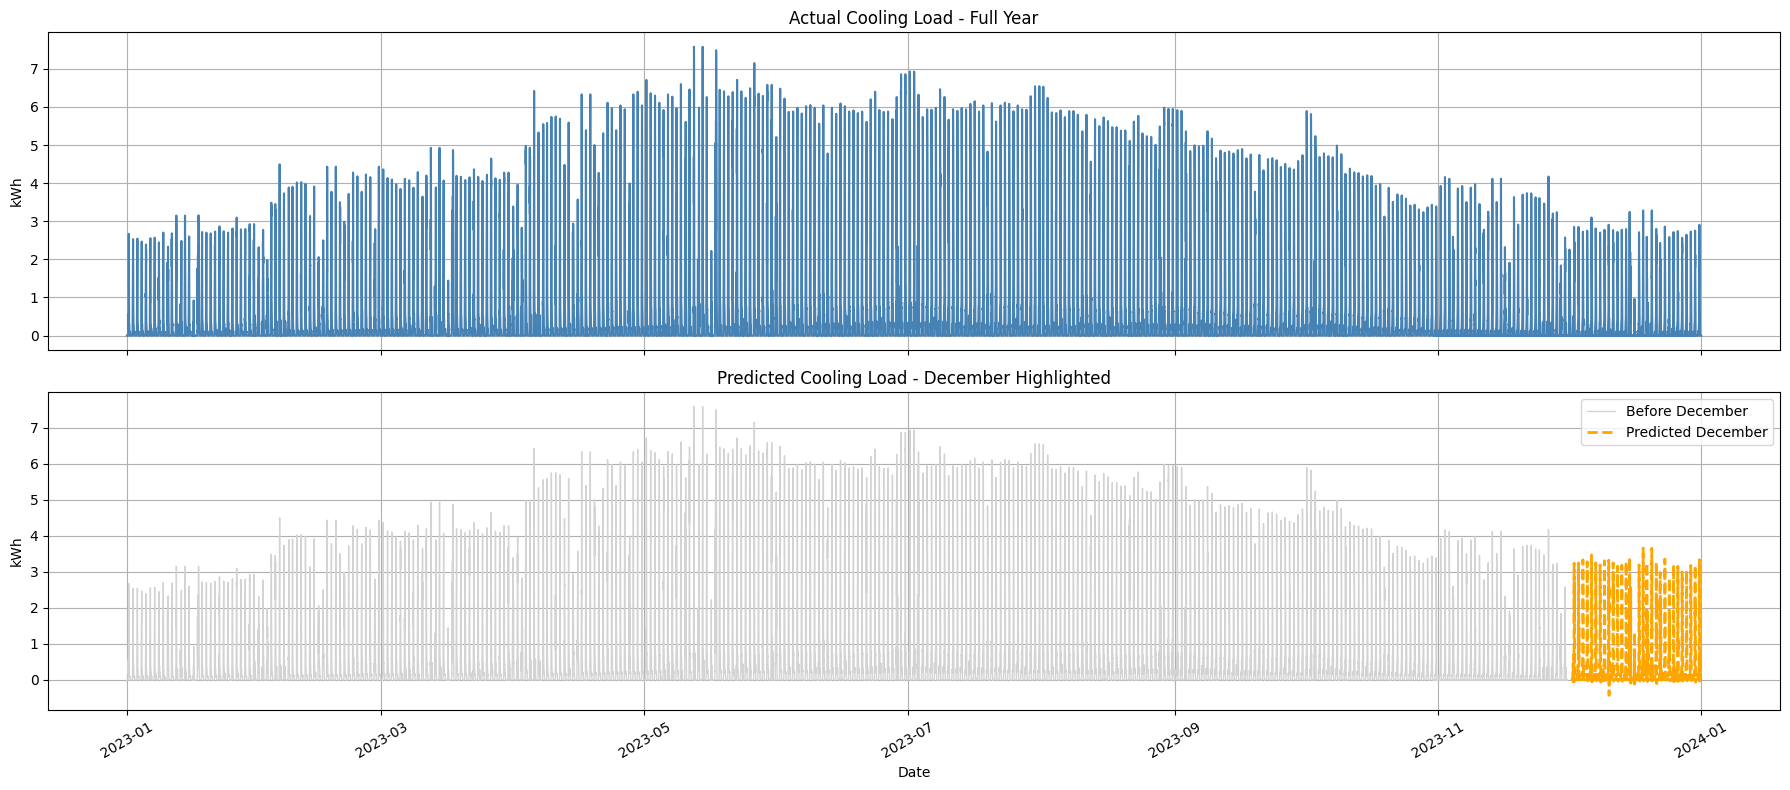


Forecasting pipeline completed successfully.


In [1]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import math
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

def load_raw_actual_data(file_path):
    """
    Loads and cleans the full-year actual cooling load data from an Excel file.

    Processing steps:
    -----------------
    - Skips the first row (header metadata)
    - Cleans column names (removes extra spaces or special characters)
    - Selects only the 'Timestamp' and 'kWh' columns
    - Converts 'Timestamp' to datetime format
    - Converts 'kWh' values to numeric (coerces invalid entries to NaN)
    - Drops rows with missing or invalid values

    Parameters:
    -----------
    file_path : str
        Full path to the Excel file containing the raw data

    Returns:
    --------
    pd.DataFrame
        Cleaned DataFrame with columns: ['Timestamp', 'Cooling System']
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Excel file not found at: {file_path}")

    df = pd.read_excel(file_path, skiprows=1)

    # Clean column names (remove strange characters like '\xa0')
    df.columns = df.columns.str.strip().str.replace('\xa0', '').str.replace('\n', ' ')
    #print("Available columns:", df.columns.tolist())

    # Extract only needed columns
    df = df[["Timestamp", "kWh"]]
    df.columns = ["Timestamp", "Cooling System"]

    # Convert types
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True, format="mixed")
    df["Cooling System"] = pd.to_numeric(df["Cooling System"], errors='coerce')
    df.dropna(inplace=True)

    return df


def load_and_prepare_data(file_path):
    """
    Loads, cleans, and splits cooling system data from an Excel file
    into training and testing datasets based on the date threshold (Dec 1, 2023).

    Processing Steps:
    -----------------
    - Loads the Excel file while skipping metadata rows
    - Cleans column names to remove special characters
    - Selects relevant columns: 'Timestamp' and 'kWh'
    - Converts 'Timestamp' to datetime and 'kWh' to numeric
    - Drops rows with invalid or missing values
    - Splits data into:
        * training set: entries before 2023-12-01
        * testing set: entries from 2023-12-01 onward

    Parameters:
    -----------
    file_path : str
        Path to the Excel file containing the raw cooling load data

    Returns:
    --------
    train_df : pd.DataFrame
        Data before December 1, 2023 (used for training)

    test_df : pd.DataFrame
        Data from December 1, 2023 onward (used for testing)
    """
    if not os.path.exists(file_path):
        print(f"Excel file not found at: {file_path}")
        return None, None

    # Load Excel and clean columns
    df = pd.read_excel(file_path, skiprows=1)
    df.columns = df.columns.str.strip().str.replace('\xa0', '').str.replace('\n', ' ')

    # Keep only relevant columns and rename for consistency
    df = df[["Timestamp", "kWh"]]
    df.columns = ["Timestamp", "Cooling System"]

    # Convert column types
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True, format='mixed')
    df["Cooling System"] = pd.to_numeric(df["Cooling System"], errors='coerce')

    # Drop missing or invalid rows
    df.dropna(inplace=True)

    # Split into training and test sets
    train_df = df[df["Timestamp"] < "2023-12-01"].copy()
    test_df = df[df["Timestamp"] >= "2023-12-01"].copy()

    print("Excel data loaded and cleaned.")
    print(f"Total records: {len(df)}")
    print(f"Training records: {len(train_df)}")
    print(f"Test records: {len(test_df)}")

    return train_df, test_df


def normalize_cooling_column(df, column="Cooling System", new_column="Cooling Normalized"):
    """
    Applies Min-Max normalization to the Cooling System column.

    This scales all values in the specified column to a range between 0 and 1,
    which is essential for training neural networks like LSTM models. Without
    normalization, large numerical values can dominate the training process and
    lead to poor convergence or unstable training.

    Adds a new normalized column to the DataFrame and returns:
    - updated df: the full DataFrame with a new normalized column
    - train_normalized: normalized values for training data
    - test_normalized: normalized values for test (December) data
    - scaler: the fitted MinMaxScaler (used later for inverse-transforming predictions)
    """

    # Ensure numeric type and remove invalid rows
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df.dropna(subset=[column], inplace=True)

    # Fit Min-Max scaler on full dataset
    scaler = MinMaxScaler()
    values = df[[column]].values
    normalized = scaler.fit_transform(values)

    # Add new normalized column
    df[new_column] = normalized

    # Re-split normalized values based on original timestamps
    train_normalized = df[df["Timestamp"] < "2023-12-01"][new_column].values
    test_normalized = df[df["Timestamp"] >= "2023-12-01"][new_column].values

    print("Normalization complete.")
    print(f"Train shape: {train_normalized.shape}")
    print(f"Test shape: {test_normalized.shape}")

    return df, train_normalized, test_normalized, scaler

# === Create LSTM-compatible sequences from time series ===
def create_lstm_sequences(data, window_size=96):
    """
    Creates input/output pairs for LSTM training from time series data.

    Args:
        data (np.ndarray): 1D array of normalized cooling values
        window_size (int): Number of previous time steps used to predict the next one

    Returns:
        X (np.ndarray): Input sequences of shape [samples, window_size, 1]
        y (np.ndarray): Corresponding targets of shape [samples, 1]
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y

# === Define LSTM Model ===
class CoolingLSTM(nn.Module):
    """
    A simple LSTM model for time series regression on cooling load data.
    """
    def __init__(self, hidden_size=64, num_layers=1):
        super(CoolingLSTM, self).__init__()
        self.input_size = 1  # Univariate input (cooling load only)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(self.hidden_size, 1)  # Single-step output

    def forward(self, x):
        # Initialize hidden and cell states (shape: [num_layers, batch, hidden_size])
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # Output shape: [batch, seq_len, hidden_size]

        # Use output from the last time step
        out = self.fc(out[:, -1, :])    # Shape: [batch, 1]
        return out

# === Create a PyTorch DataLoader from numpy arrays ===
def get_data_loader(X, y, batch_size=64):
    """
    Converts sequences into a PyTorch DataLoader.

    Args:
        X (np.ndarray): Input sequences [samples, window_size, 1]
        y (np.ndarray): Output targets [samples, 1]
        batch_size (int): Number of samples per training batch

    Returns:
        DataLoader: PyTorch DataLoader with shuffled batches
    """
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

def train_model(X_train, y_train, model, epochs=20, lr=0.001, batch_size=64):
    """
    Trains the provided LSTM model using MSE + zero-error penalty.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = get_data_loader(X_train, y_train, batch_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("Starting training with zero-sensitive loss...")
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0

        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)

            # === Custom loss: MSE + penalty when true value is zero ===
            mse = criterion(output, y_batch)
            zero_mask = (y_batch == 0).float()
            penalty = torch.mean(zero_mask * torch.abs(output - y_batch))
            loss = mse + 0.5 * penalty  # <-- 0.5 weight is tunable

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)

        # === Evaluate on train set for logging ===
        model.eval()
        val_loader = get_data_loader(X_train, y_train, batch_size=batch_size)
        all_preds, all_targets = [], []

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                val_output = model(X_val)
                all_preds.append(val_output.cpu().numpy())
                all_targets.append(y_val.cpu().numpy())

        predictions = np.concatenate(all_preds).flatten()
        targets = np.concatenate(all_targets).flatten()

        mae = mean_absolute_error(targets, predictions)
        rmse = math.sqrt(mean_squared_error(targets, predictions))

        print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {avg_loss:.6f} - MAE: {mae:.6f} - RMSE: {rmse:.6f}")
        model.train()

    print("Training complete.")
    return model


def predict(model, X_data, scaler):
    """
    Generates predictions using a trained LSTM model and returns them
    in their original (denormalized) form.

    Args:
        model (nn.Module): Trained PyTorch LSTM model
        X_data (np.ndarray): Normalized input sequences with shape (samples, window_size, 1)
        scaler (MinMaxScaler): Fitted scaler used for inverse transformation

    Returns:
        np.ndarray: Denormalized predictions (in kWh)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # No need to unsqueeze; X_data is already 3D: (batch, seq_len, input_size)
    X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(X_tensor).cpu().numpy().flatten()

    # Convert predictions back to original kWh scale
    return scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()


def plot_predictions_with_time(y_true, y_pred, timestamps,
                               title="Cooling Load Prediction - December",
                               save_path="cooling_december_prediction.png"):
    """
    Plots predicted vs. actual cooling load for December only.

    Parameters:
    - y_true: actual values (denormalized)
    - y_pred: predicted values (denormalized)
    - timestamps: matching timestamps for y_true and y_pred
    - title: plot title
    - save_path: path to save the image
    """
    plt.figure(figsize=(15, 5))
    plt.plot(timestamps, y_true, label="Actual", linewidth=2)
    plt.plot(timestamps, y_pred, label="Predicted", linewidth=2)

    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel("Cooling Load (kWh)")
    plt.xticks(rotation=45)

    # Dynamic Y-axis range based on data
    y_min = min(min(y_true), min(y_pred))
    y_max = max(max(y_true), max(y_pred))
    plt.ylim(y_min - 0.05, y_max + 0.1)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to: {save_path}")
    plt.show()


def plot_full_year_with_december_overlay(cooling_df, dec_df, save_path="full_year_with_december_overlay.png"):
    """
    Plots the full-year actual cooling data and overlays December actual + predicted values.
    """
    plt.figure(figsize=(18, 6))
    plt.plot(cooling_df['Timestamp'], cooling_df['Cooling System'], label='Actual (All Year)', alpha=0.3)
    plt.plot(dec_df['Timestamp'], dec_df['Actual Cooling Load (kWh)'], label='Actual (December)', linewidth=2)
    plt.plot(dec_df['Timestamp'], dec_df['Predicted Cooling Load (kWh)'], label='Predicted (December)', linewidth=2)

    plt.title('Cooling Load - Full Year with December Overlay')
    plt.xlabel('Timestamp')
    plt.ylabel('Cooling Load (kWh)')
    plt.xticks(rotation=45)

    # Consistent Y-axis based on full data range
    all_values = pd.concat([
        cooling_df['Cooling System'],
        dec_df['Actual Cooling Load (kWh)'],
        dec_df['Predicted Cooling Load (kWh)']
    ])
    plt.ylim(all_values.min() - 0.05, all_values.max() + 0.1)

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


def plot_actual_full_year(cooling_df, save_path="cooling_actual_full_year.png"):
    """
    Plots the actual full-year cooling load without predictions.
    """
    plt.figure(figsize=(18, 5))
    plt.plot(cooling_df['Timestamp'], cooling_df['Cooling System'],
             color='blue', alpha=0.8, label="Actual Cooling Load")

    plt.title("Cooling Load - Full Year (Actual Only)")
    plt.xlabel("Timestamp")
    plt.ylabel("Cooling Load (kWh)")
    plt.xticks(rotation=45)

    # Y-axis scaled to actual values
    plt.ylim(cooling_df["Cooling System"].min() - 0.05,
             cooling_df["Cooling System"].max() + 0.1)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

def plot_predictions_with_time(y_true, y_pred, timestamps,
                               title="Cooling Load Prediction - December",
                               save_path="cooling_december_prediction.png"):
    """
    Stacked plot:
    - Top: Actual cooling load (December)
    - Bottom: Predicted cooling load (December)
    """
    plt.figure(figsize=(15, 8))

    # === 1. Actual values ===
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(timestamps, y_true, label="Actual", color='blue', linewidth=2)
    ax1.set_title("Actual Cooling Load - December 2023")
    ax1.set_ylabel("Cooling Load (kWh)")
    ax1.grid(True)
    ax1.tick_params(axis='x', labelrotation=45)

    # === 2. Predicted values ===
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(timestamps, y_pred, label="Predicted", color='orange', linewidth=2)
    ax2.set_title("Predicted Cooling Load - December 2023")
    ax2.set_xlabel("Timestamp")
    ax2.set_ylabel("Cooling Load (kWh)")
    ax2.grid(True)
    ax2.tick_params(axis='x', labelrotation=45)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Stacked plot saved to: {save_path}")
    plt.show()

def plot_stacked_full_year_with_december_prediction(df_actual, dec_df, save_path="stacked_full_year_with_prediction.png"):
    """
    Plots a stacked figure:
    - Top: Full-year actual cooling load
    - Bottom: Full-year timeline again, but December predictions in orange
    """
    df_actual = df_actual.copy()
    df_actual['Timestamp'] = pd.to_datetime(df_actual['Timestamp'])
    dec_df['Timestamp'] = pd.to_datetime(dec_df['Timestamp'])

    # Create predicted December column in full actual dataframe
    df_actual['Predicted December'] = np.nan
    pred_map = dict(zip(dec_df['Timestamp'], dec_df['Predicted Cooling Load (kWh)']))
    df_actual['Predicted December'] = df_actual['Timestamp'].map(pred_map)

    # Separate pre-December from December predicted values
    is_december = df_actual['Timestamp'].dt.month == 12
    df_actual['Before December'] = np.where(is_december, np.nan, df_actual['Cooling System'])

    # === Plotting ===
    fig, axs = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

    # Top: Full-year actual cooling load
    axs[0].plot(df_actual['Timestamp'], df_actual['Cooling System'], color='steelblue', linewidth=1.5)
    axs[0].set_title("Actual Cooling Load - Full Year")
    axs[0].set_ylabel("kWh")
    axs[0].grid(True)

    # Bottom: Full year again, but highlight December predictions in orange
    axs[1].plot(df_actual['Timestamp'], df_actual['Before December'], color='lightgray', linewidth=1, label='Before December')
    axs[1].plot(df_actual['Timestamp'], df_actual['Predicted December'], color='orange', linestyle='--', linewidth=2, label='Predicted December')
    axs[1].set_title("Predicted Cooling Load - December Highlighted")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("kWh")
    axs[1].legend()
    axs[1].grid(True)

    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

def main():
    print("=== Cooling Load Forecasting with LSTM ===\n")

    # === File path to the Excel file ===
    file_path = "/content/drive/MyDrive/datasets/RnD_CriticalLoadHistory_2023.xlsx"

    # === Step 1: Load raw full-year data (for final plot overlay) ===
    print("[Step 1] Loading full-year data...")
    df_actual = load_raw_actual_data(file_path)

    # === Step 2: Load and split data into train/test ===
    print("[Step 2] Splitting dataset into training and test sets...")
    train_df, test_df = load_and_prepare_data(file_path)

    # === Step 3: Normalize full dataset ===
    print("[Step 3] Applying Min-Max normalization...")
    df_combined = pd.concat([train_df, test_df]).reset_index(drop=True)
    df_combined, train_normalized, test_normalized, scaler = normalize_cooling_column(df_combined)

    # === Step 4: Create LSTM sequences for training ===
    print("[Step 4] Creating input sequences for LSTM...")
    window_size = 96
    X_train, y_train = create_lstm_sequences(train_normalized, window_size)

    # === Step 5: Train LSTM model ===
    print("[Step 5] Training LSTM model...")
    model = CoolingLSTM(hidden_size=64)
    model = train_model(X_train, y_train, model, epochs=20, lr=0.001)

    # === Step 6: Save trained model (optional) ===
    torch.save(model, "cooling_lstm_fullmodel.pth")
    print("[Step 6] Trained model saved to: cooling_lstm_fullmodel.pth")

    # === Step 7: Prepare December input sequences and predict ===
    print("[Step 7] Making predictions for December 2023...")
    X_test, y_test = create_lstm_sequences(test_normalized, window_size)
    december_predictions = predict(model, X_test, scaler)

    # === Step 8: Denormalize ground truth values ===
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # === Step 9: Evaluation ===
    print("[Step 8] Evaluating prediction performance...")
    from sklearn.metrics import mean_absolute_percentage_error, r2_score

    mae = mean_absolute_error(y_test_original, december_predictions)
    rmse = math.sqrt(mean_squared_error(y_test_original, december_predictions))
    mape = mean_absolute_percentage_error(y_test_original, december_predictions) * 100
    r2 = r2_score(y_test_original, december_predictions)

    print("\nEvaluation Metrics for December Predictions")
    print("-------------------------------------------")
    print(f"Mean Absolute Error (MAE):            {mae:.3f} kWh")
    print(f"Root Mean Squared Error (RMSE):       {rmse:.3f} kWh")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared Score (R²):                 {r2:.4f}\n")

    # === Step 10: Save results to Excel ===
    timestamps_december = test_df["Timestamp"].iloc[window_size:].reset_index(drop=True)
    results_df = pd.DataFrame({
        "Timestamp": timestamps_december,
        "Actual Cooling Load (kWh)": y_test_original,
        "Predicted Cooling Load (kWh)": december_predictions
    })

    output_excel = "december_predictions.xlsx"
    results_df.to_excel(output_excel, index=False)
    print(f"[Step 9] Predictions exported to: {output_excel}")

    # === Step 11: Plot stacked actual + predicted December ===
    print("[Step 10] Plotting stacked December actual + predicted values...")
    plot_predictions_with_time(
        y_true=y_test_original,
        y_pred=december_predictions,
        timestamps=timestamps_december,
        title="Cooling Load Prediction - December",
        save_path="cooling_december_prediction.png"
    )

    # === Step 12: Overlay on full year ===
    print("[Step 11] Plotting full year with December overlay...")
    plot_full_year_with_december_overlay(
        cooling_df=df_actual,
        dec_df=results_df,
        save_path="full_year_with_december_overlay.png"
    )

    # === Step 13: Plot full actual data only ===
    print("[Step 12] Plotting actual full-year data...")
    plot_actual_full_year(df_actual)

    # === Step 14: Stacked full-year with predicted December only ===
    print("[Step 13] Plotting stacked full-year with predicted December...")
    plot_stacked_full_year_with_december_prediction(
        df_actual=df_actual,
        dec_df=results_df,
        save_path="stacked_full_year_with_prediction.png"
    )

    print("\nForecasting pipeline completed successfully.")

if __name__ == "__main__":
    main()

